# Neural Networks models to distinguish the gender of individuals in pictures

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print(tf.__version__)

C:\Users\Alejandro Ponce\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.16.1


## 1. Preprocessing of the data

### 1.1 Reading and understanding of the data

In [2]:
data_set = {}
# data is defined in different folds so we need to store in in the same place
for i in range(5):
    data_set[i] = pd.read_csv(f'./Adience/fold_{i}_data.txt', sep = "\t") # as by default the separator is ',' we need to state
    
# however we want to store it in a dataset instead of a dictionary
# so we concatenate the data

data_set = pd.concat([data_set[i] for i in range(5)], ignore_index = True)
data_set.info()
unique_labels_gender = data_set['gender'].unique()
unique_labels_age = data_set['age'].unique()
print(unique_labels_gender)
print(unique_labels_age)
data_set.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 18622 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB
['f' 'm' nan 'u']
['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' nan '(38, 48)' '35' '3' '55' '58' '22' '13' '45' '36'
 '23' '(38,

user_id                original_image  face_id       age gender     x  \
0  30601258@N03  10399646885_67c7d20df9_o.jpg        1  (25, 32)      f     0   
1  30601258@N03  10424815813_e94629b1ec_o.jpg        2  (25, 32)      m   301   
2  30601258@N03  10437979845_5985be4b26_o.jpg        1  (25, 32)      f  2395   
3  30601258@N03  10437979845_5985be4b26_o.jpg        3  (25, 32)      m   752   
4  30601258@N03  11816644924_075c3d8d59_o.jpg        2  (25, 32)      m   175   

      y    dx    dy  tilt_ang  fiducial_yaw_angle  fiducial_score  
0   414  1086  1383      -115                  30              17  
1   105   640   641         0                   0              94  
2   876   771   771       175                 -30              74  
3  1255   484   485       180                   0              47  
4    80   769   768       -75                   0              34

We can observe that we have 19370 entries of data. However, only 18591 have a value for gender and 18622 for age. We need to look into that in the future, as the may not be useful for training/testing/validation. As we are going to work with these to variables (age and gender) let's check how the distribution is across the data. 

Also we can check that the possible values for gender are 'f' (female), 'm' (male) and 'u' (undefined). For age, we can observe that we have a mix of individual values and intervals. In this part we will make the following changes:
 - Drop all the rows that contain NaN values (in any column) of the data set as they are not interesting and won't lead to ueful information.
 - Group age by intervals which make sense. On the original data set we have different entries for example for (0,2) and '2' which should be in the same interval.
 - In the gender variable we will need to drop 'u', as it is not useful beacuse we are trying to classify between male and female.
 - Joining the two columns user_id and original_image, as it is just the way in which the pictures are stored in the data set. We can combine them to create a path.


### 1.2 Modifications and feature engineering

In [3]:
df = data_set[['age', 'gender', 'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score']].copy()

Firstly, we will combine user_id and original_image into a new variable named image_path which will contain the path in the folder to the picture described by the data:

In [4]:
image_path = []
for row in data_set.iterrows():
    path = f"./Adience/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    image_path.append(path)
df['image_path'] = image_path
df.head()

age gender     x     y    dx    dy  tilt_ang  fiducial_yaw_angle  \
0  (25, 32)      f     0   414  1086  1383      -115                  30   
1  (25, 32)      m   301   105   640   641         0                   0   
2  (25, 32)      f  2395   876   771   771       175                 -30   
3  (25, 32)      m   752  1255   484   485       180                   0   
4  (25, 32)      m   175    80   769   768       -75                   0   

   fiducial_score                                         image_path  
0              17  ./Adience/faces/30601258@N03/coarse_tilt_align...  
1              94  ./Adience/faces/30601258@N03/coarse_tilt_align...  
2              74  ./Adience/faces/30601258@N03/coarse_tilt_align...  
3              47  ./Adience/faces/30601258@N03/coarse_tilt_align...  
4              34  ./Adience/faces/30601258@N03/coarse_tilt_align...

Second, we drop the NaNs values as we can't work with them. This function will search for NaN's in any column and delete the complete row where they were stored:

In [5]:
df = df.dropna()

Third, we will group age old values into intervals. Unfortunatley its impossible to make the intervals have the same length as we are constrained by some of them were already given and are of varying lenghts. We tried keeping them as short as possible while still being an interval:

In [6]:
# The intervals will be the following
#    "0-2" containing: ['(0, 2)', '2'],
#    "4-6" containing: ['(4, 6)', '3'], 
#    "8-23" containing: ['(15, 20)', '(8, 12)', '22', '13', '23', '(8, 23)'],
#    "25-32" containing: ['(25, 32)', '(27, 32)', '29', '32'],
#    "33-37" containing: ['35', '36', '34'],
#    "38-48" containing: ['(38, 43)', '(38, 48)', '45', '(38, 42)', '42', '46'],
#    "48-53" containing: ['(48, 53)'],
#    "54-59" containing: ['55', '58', '57', '56'],
#    "60-100" containing: ['(60, 100)'],

mapping_dict = {'(0, 2)': '0-2', '2': '0-2',
               '(4, 6)': '3-6', '3': '3-6',
               '(15, 20)': '8-23', '22': '8-23', '13': '8-23', '23': '8-23', '(8, 23)': '8-23',  '(8, 12)': '8-23',
               '(25, 32)': '25-32', '(27, 32)': '25-32', '29': '25-32', '32': '25-32',
               '35': '33-37', '36': '33-37', '34': '33-37',
               '(38, 43)': '38-48', '(38, 48)': '38-48', '45': '38-48', '(38, 42)': '38-48',  '42': '38-48', '46': '38-48',
               '(48, 53)': '48-53',
               '55': '54-59', '58': '54-59', '57': '54-59', '56': '54-59',
               '(60, 100)': '60-100'
    
}

for idx, each in enumerate(df.age):
    df.age.loc[idx] = mapping_dict[each]
df.age.value_counts(dropna = False)

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx]

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = mapping_dict[each]
C:\Users\Alejandro Ponce\AppData\Local\Temp\ipykernel_8212\2382097070.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

age
25-32        4728
8-23         4016
0-2          2454
38-48        2353
3-6          2137
60-100        832
48-53         808
33-37         385
(25, 32)      320
(0, 2)        179
54-59         103
(38, 43)       77
(8, 12)        50
(60, 100)      35
(15, 20)       34
(48, 53)       19
(4, 6)         13
35              6
55              2
Name: count, dtype: int64

In [7]:
df.age.value_counts(dropna = False)

age
25-32        4728
8-23         4016
0-2          2454
38-48        2353
3-6          2137
60-100        832
48-53         808
33-37         385
(25, 32)      320
(0, 2)        179
54-59         103
(38, 43)       77
(8, 12)        50
(60, 100)      35
(15, 20)       34
(48, 53)       19
(4, 6)         13
35              6
55              2
Name: count, dtype: int64

In [8]:
# for some reason some values are not changed so we opted for removing them
df = df[df['age'] != '55']
df = df[df['age'] != '35']
df = df[df['age'] != '(4, 6)']
df = df[df['age'] != '(48, 53)']
df = df[df['age'] != '(15, 20)']
df = df[df['age'] != '(60, 100)']
df = df[df['age'] != '(8, 12)']
df = df[df['age'] != '(38, 43)']
df = df[df['age'] != '(0, 2)']
df = df[df['age'] != '(25, 32)']
df.age.value_counts(dropna = False)

age
25-32     4728
8-23      4016
0-2       2454
38-48     2353
3-6       2137
60-100     832
48-53      808
33-37      385
54-59      103
Name: count, dtype: int64

Fourth, we will eliminate the 'u' values of the gender variable as they are not associated with either males or females and the objective of this work is to distinguish between them:

In [9]:
df = df[df.gender != 'u'].copy()

Lastly, we will create some mapping of both age and gender. We will map gender as 0 (female) and 1 (male) and age with values from 0 to 8 for the intervals created:

In [10]:
gender_mapping = {
    'f' : 0,
    'm' : 1
}

age_mapping = {
    '0-2'  :0,
    '3-6'  :1,
    '8-23' :2,
    '25-32':3,
    '33-37':4,
    '38-48':5,
    '48-53':6,
    '54-59': 7,
    '60-100': 8
}

df['age'] = df['age'].apply(lambda a: age_mapping[a])
df['gender'] = df['gender'].apply(lambda g: gender_mapping[g])
df.head()

age  gender     x     y    dx    dy  tilt_ang  fiducial_yaw_angle  \
0    3       0     0   414  1086  1383      -115                  30   
1    3       1   301   105   640   641         0                   0   
2    3       0  2395   876   771   771       175                 -30   
3    3       1   752  1255   484   485       180                   0   
4    3       1   175    80   769   768       -75                   0   

   fiducial_score                                         image_path  
0              17  ./Adience/faces/30601258@N03/coarse_tilt_align...  
1              94  ./Adience/faces/30601258@N03/coarse_tilt_align...  
2              74  ./Adience/faces/30601258@N03/coarse_tilt_align...  
3              47  ./Adience/faces/30601258@N03/coarse_tilt_align...  
4              34  ./Adience/faces/30601258@N03/coarse_tilt_align...

## 1.3 Graphs 

Text(0.5, 0, 'Number of people')

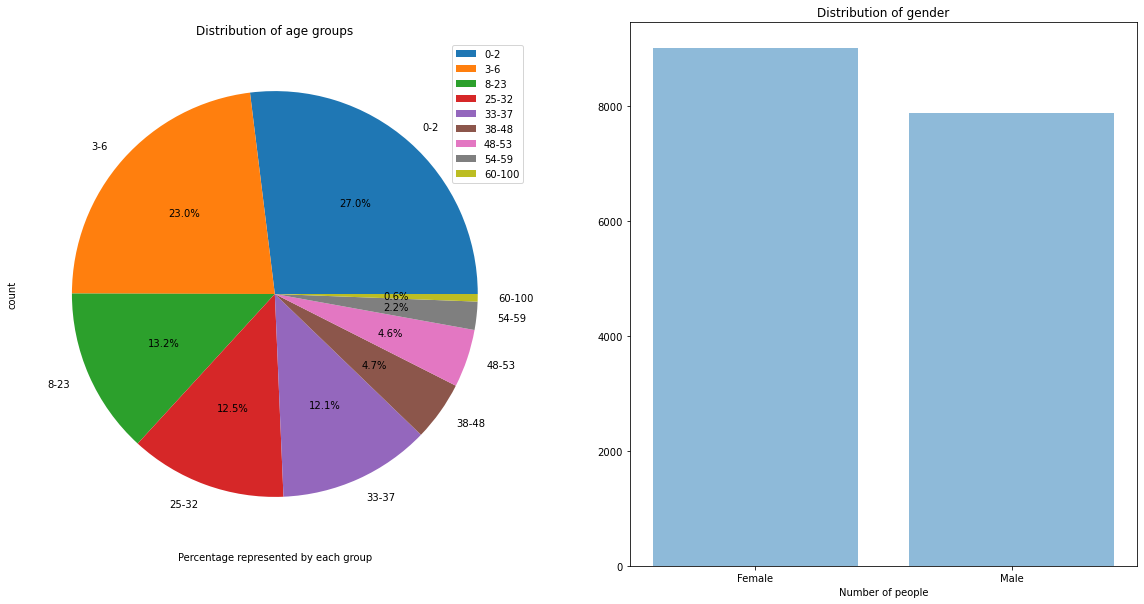

In [11]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Distribution of age groups')
plt.xlabel('Percentage represented by each group')
df.age.value_counts().plot.pie(autopct = "%1.1f%%", labels = age_mapping)
plt.legend()
plt.subplot(1,2,2)
gender = ['Female','Male']
plt.bar(gender, df.gender.value_counts(), align = 'center', alpha = 0.5)
plt.title('Distribution of gender')
plt.xlabel('Number of people')

As we can see the gender is pretty equally distributed which is good for the training of the future models. However, the age has a few groups which are very small. In the future, we will have to see if errors are in this groups whoch could be due to small training group for this age groups. in that case we will reorganise.

## 1.4 Creation of datasets

The X part will, for the moment, contain de image path. Y will contain the gender of the person in the image. we will divide the dataset into a 75:25 training to testing split:

In [12]:
X = df[['image_path']]
y = df[['gender']]

from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size = 0.25, random_state = 27)

print('Train data shape {}'.format(X_training.shape))
print('Test data shape {}'.format(X_testing.shape))

Train data shape (12671, 1)
Test data shape (4224, 1)


## 1.5 Resizing of the images

We will create different data sets with different image reduction, so in the futrue we can compare model performance:

In [13]:
from PIL import Image
training_images_227, testing_images_227 = [], []

for row in X_training.iterrows():
    image = Image.open(row[1].image_path)
    image = image.resize((227, 227))   
    data = np.asarray(image)
    training_images_227.append(data)

for row in X_testing.iterrows():
    image = Image.open(row[1].image_path)
    image = image.resize((227, 227))  
    data = np.asarray(image)
    testing_images_227.append(data)
    
training_images_227 = np.asarray(training_images_227)
testing_images_227 = np.asarray(testing_images_227)

print('Training images (227 x 227) shape {}'.format(training_images_227.shape))
print('Testing images (227 x 227) shape {}'.format(testing_images_227.shape))

Training images (227 x 227) shape (12671, 227, 227, 3)
Testing images (227 x 227) shape (4224, 227, 227, 3)


## 2.1 Model for gender prediction

For this model we have based our neural network on a paper that discusses age and gender classifications using neural networks.

We first need to set some parameters for our model. We will use batch size of 50 and a limit of 20 epochs as after a few trials we saw that the early stopper triggered between 10-15 epochs. 

Also, we need to set the size of the target and the inputs and some other parameters for the neural network to work:

In [14]:
# According to paper
batch_size = 50
epochs = 20
target_size = (227, 227) 
input_shape = (227, 227, 3) 

# We set random seed, so that our results can be reproducted
SEED = 10
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

According to the paper, training should be performed using stochastic gradient descent where the initial learning rate is 0.001 and reduced to 0.0001 after 10000 iterations.

In [15]:
import math

def step_decay(epoch):
    init_learning_rate, drop, epochs_drop = 0.001, 0.1, 10000
    learning_rate = init_learning_rate * math.pow(drop, math.floor((1 + epoch)/epochs_drop))
    return learning_rate
    
weight_init = keras.initializers.TruncatedNormal(mean = 0.0, stddev = 0.01, seed = SEED)



We now build the model according to the description of the data set:

In [16]:
def build_adience_gender_optimal():
    # Initialize the model as sequential 
    model = keras.models.Sequential()
    
    # First convolution in 2D: 96 filters of size 7 x 7 kernel and ReLu activation function
    # Max pooling with 3 x 3 kernel
    model.add(Conv2D(96, (7, 7), input_shape = input_shape, strides = 4, padding = 'valid', 
                     activation = 'relu', kernel_initializer = weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2, padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input = x, alpha = 0.0001, beta = 0.75)))
    
    # Second convolution in 2D: 256 filters of size 5 x 5 kernel and ReLu activation function
    # Max pooling with 3 x 3 kernel
    model.add(Conv2D(256, (5, 5), padding = 'same', activation = 'relu', kernel_initializer = weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2, padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input = x, alpha = 0.0001, beta = 0.75)))
    
    # Third convolution in 3D: 384 filters of size 3x3 kernel and ReLu activation function
    # Max pooling with 3 x 3 kernel
    model.add(keras.layers.Conv2D(384, (3, 3), padding = 'same', activation = 'relu', kernel_initializer = weight_init))
    model.add(keras.layers.MaxPool2D(pool_size = (3, 3), strides = 2, padding = 'same'))
    
    # We flatten the model 
    model.add(Flatten())
    
    # First connected layer, receives as input the last convolutional layer
    # ReLu activation function
    model.add(Dense(512, activation = "relu", kernel_initializer = weight_init))
    # Dropout value of 50%, e.g. setting neurons output to 0
    model.add(Dropout(0.5))
    
    # Second connected layer, receives as input the previous layer
    # ReLu activation function
    model.add(Dense(512, activation = 'relu', kernel_initializer = weight_init))
    # Dropout value of 50%, e.g. setting neurons output to 0
    model.add(Dropout(0.5))
    
    # Third connected layer that maps the gender classification
    # Sigmoid activation function
    model.add(Dense(1, activation ='sigmoid', kernel_initializer = weight_init))
    
    # Lastly, we connect to a softmax layer that assigns a probability to each class (male or female)
    # We set the loss fucntion to a cross entropy and the valdiation metric to accuracy
    model.compile(optimizer = keras.optimizers.SGD(learning_rate = 1e-3, momentum = 0.0),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

    return model

We now build the model and check that we have the desired structure:

In [25]:
from tensorflow.keras.utils import plot_model
model_batch_10 = build_adience_gender_optimal()
model_batch_5 = build_adience_gender_optimal()
model_batch_1 = build_adience_gender_optimal()
model_batch_10.summary()

C:\Users\Alejandro Ponce\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 96)          │          14,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       9,634,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,411,457 (43.53 MB)

 Trainable params: 11,411,457 (43.53 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
patience = 3
verbose = 1
def get_call_backs():
     lrate = keras.callbacks.LearningRateScheduler(step_decay)
     mcp = ModelCheckpoint('model.keras')
     es = EarlyStopping(verbose = verbose, patience = patience)
    
     return [lrate, mcp, es]


In [27]:
history_10 = model_batch_10.fit(
    training_images_227, y_training, 
    batch_size = 10, 
    epochs = 100, 
    validation_data = (testing_images_227, y_testing), 
    callbacks=get_call_backs())

Epoch 1/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 241s 189ms/step - accuracy: 0.5383 - loss: 0.6910 - val_accuracy: 0.5964 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 2/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 238s 188ms/step - accuracy: 0.5788 - loss: 0.6786 - val_accuracy: 0.6506 - val_loss: 0.6455 - learning_rate: 0.0010
Epoch 3/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 241s 190ms/step - accuracy: 0.6272 - loss: 0.6443 - val_accuracy: 0.6880 - val_loss: 0.5826 - learning_rate: 0.0010
Epoch 4/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 236s 186ms/step - accuracy: 0.6724 - loss: 0.6026 - val_accuracy: 0.7093 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 5/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 238s 188ms/step - accuracy: 0.7073 - loss: 0.5606 - val_accuracy: 0.7455 - val_loss: 0.5147 - learning_rate: 0.0010
Epoch 6/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 240s 189ms/step - accuracy: 0.7415 - loss: 0.5262 - val_accuracy: 0.7649 - val_loss: 0.4865 - learning_rate: 0.0010
Epoch 7/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 239

In [28]:
history_5 = model_batch_5.fit(
    training_images_227, y_training, 
    batch_size = 5, 
    epochs = 100, 
    validation_data = (testing_images_227, y_testing), 
    callbacks = get_call_backs())

Epoch 1/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 298s 117ms/step - accuracy: 0.5423 - loss: 0.6896 - val_accuracy: 0.6236 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 2/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 270s 107ms/step - accuracy: 0.6017 - loss: 0.6619 - val_accuracy: 0.6929 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 3/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 268s 106ms/step - accuracy: 0.6742 - loss: 0.5986 - val_accuracy: 0.7313 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 4/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 269s 106ms/step - accuracy: 0.7236 - loss: 0.5437 - val_accuracy: 0.7656 - val_loss: 0.4807 - learning_rate: 0.0010
Epoch 5/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 269s 106ms/step - accuracy: 0.7640 - loss: 0.4916 - val_accuracy: 0.7952 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 6/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 270s 107ms/step - accuracy: 0.7927 - loss: 0.4403 - val_accuracy: 0.8205 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 7/100
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 274

In [29]:
history_1 = model_batch_1.fit(
    training_images_227, y_training, 
    batch_size = 1, 
    epochs = 100, 
    validation_data = (testing_images_227, y_testing), 
    callbacks = get_call_backs())

Epoch 1/100
12671/12671 ━━━━━━━━━━━━━━━━━━━━ 533s 42ms/step - accuracy: 0.5389 - loss: 0.6896 - val_accuracy: 0.6615 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 2/100
12671/12671 ━━━━━━━━━━━━━━━━━━━━ 529s 42ms/step - accuracy: 0.6524 - loss: 0.6195 - val_accuracy: 0.6636 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 3/100
12671/12671 ━━━━━━━━━━━━━━━━━━━━ 526s 42ms/step - accuracy: 0.7021 - loss: 0.5721 - val_accuracy: 0.7450 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 4/100
12671/12671 ━━━━━━━━━━━━━━━━━━━━ 526s 42ms/step - accuracy: 0.7511 - loss: 0.4980 - val_accuracy: 0.7865 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 5/100
12671/12671 ━━━━━━━━━━━━━━━━━━━━ 522s 41ms/step - accuracy: 0.8012 - loss: 0.4178 - val_accuracy: 0.8151 - val_loss: 0.3985 - learning_rate: 0.0010
Epoch 6/100
12671/12671 ━━━━━━━━━━━━━━━━━━━━ 525s 41ms/step - accuracy: 0.8371 - loss: 0.3605 - val_accuracy: 0.8402 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 7/100
12671/12671 ━━━━━━━━━━━━━━━━

In [30]:
model_batch_50 = build_adience_gender_optimal()
history_50 = model_batch_50.fit(
    training_images_227, y_training, 
    batch_size = 50, 
    epochs = 200, 
    validation_data = (testing_images_227, y_testing), 
    callbacks = get_call_backs())

C:\Users\Alejandro Ponce\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 196s 770ms/step - accuracy: 0.5293 - loss: 0.6920 - val_accuracy: 0.5488 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 2/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 202s 796ms/step - accuracy: 0.5538 - loss: 0.6891 - val_accuracy: 0.5634 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 3/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 202s 794ms/step - accuracy: 0.5682 - loss: 0.6868 - val_accuracy: 0.6068 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 4/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 202s 797ms/step - accuracy: 0.5720 - loss: 0.6832 - val_accuracy: 0.6250 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 207s 816ms/step - accuracy: 0.5851 - loss: 0.6784 - val_accuracy: 0.6357 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 6/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 205s 808ms/step - accuracy: 0.5945 - loss: 0.6730 - val_accuracy: 0.6446 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 7/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 203s 802ms/step -

Visualization of the results:

In [46]:
from tensorflow.keras.models import load_model, save_model

model_batch_1.save('model_gender_batch_1.keras')
model_batch_5.save('model_gender_batch_5.keras'
model_batch_10.save('model_gender_batch_10.keras')
model_batch_50.save('model_gender_batch_50.keras')

SyntaxError: invalid syntax (3491761234.py, line 5)

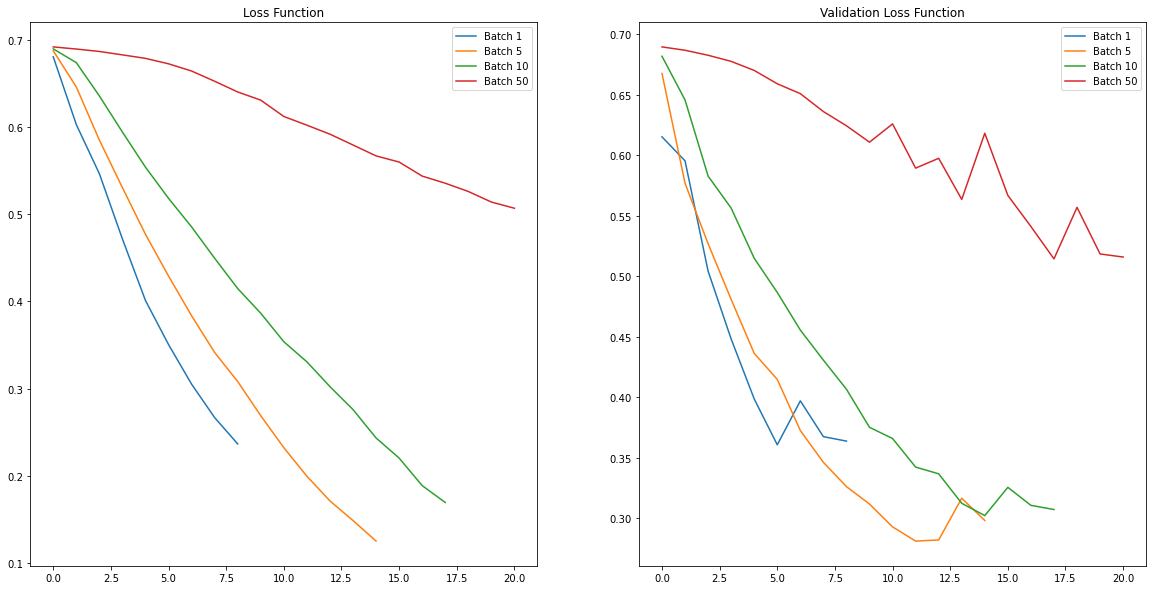

In [44]:
# Plot loss function value through epochs
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(history_1.history['loss'], label = 'Batch 1')
plt.plot(history_5.history['loss'], label = 'Batch 5')
plt.plot(history_10.history['loss'], label = 'Batch 10')
plt.plot(history_50.history['loss'], label = 'Batch 50')
plt.legend()
plt.title('Loss Function')
plt.subplot(1,2,2)
plt.plot(history_1.history['val_loss'], label = 'Batch 1')
plt.plot(history_5.history['val_loss'], label = 'Batch 5')
plt.plot(history_10.history['val_loss'], label = 'Batch 10')
plt.plot(history_50.history['val_loss'], label = 'Batch 50')
plt.legend()
plt.title('Validation Loss Function')
plt.show()

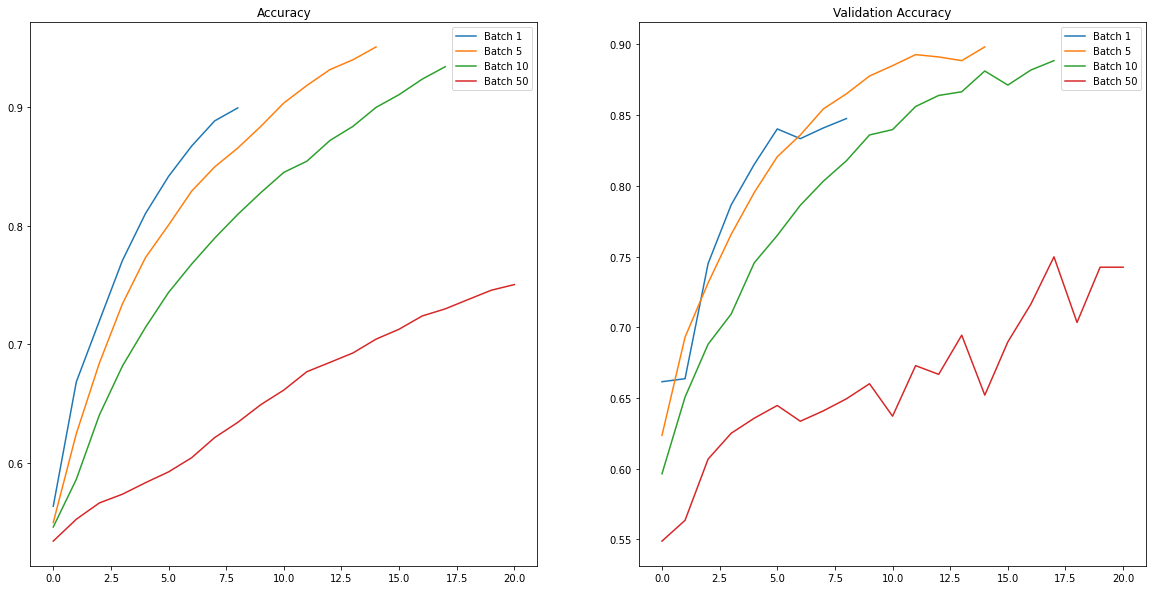

In [45]:
# Plot loss function value through epochs
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label = 'Batch 1')
plt.plot(history_5.history['accuracy'], label = 'Batch 5')
plt.plot(history_10.history['accuracy'], label = 'Batch 10')
plt.plot(history_50.history['accuracy'], label = 'Batch 50')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history_1.history['val_accuracy'], label = 'Batch 1')
plt.plot(history_5.history['val_accuracy'], label = 'Batch 5')
plt.plot(history_10.history['val_accuracy'], label = 'Batch 10')
plt.plot(history_50.history['val_accuracy'], label = 'Batch 50')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

Text(0.5, 1.0, 'Number of epochs needed for each batch size')

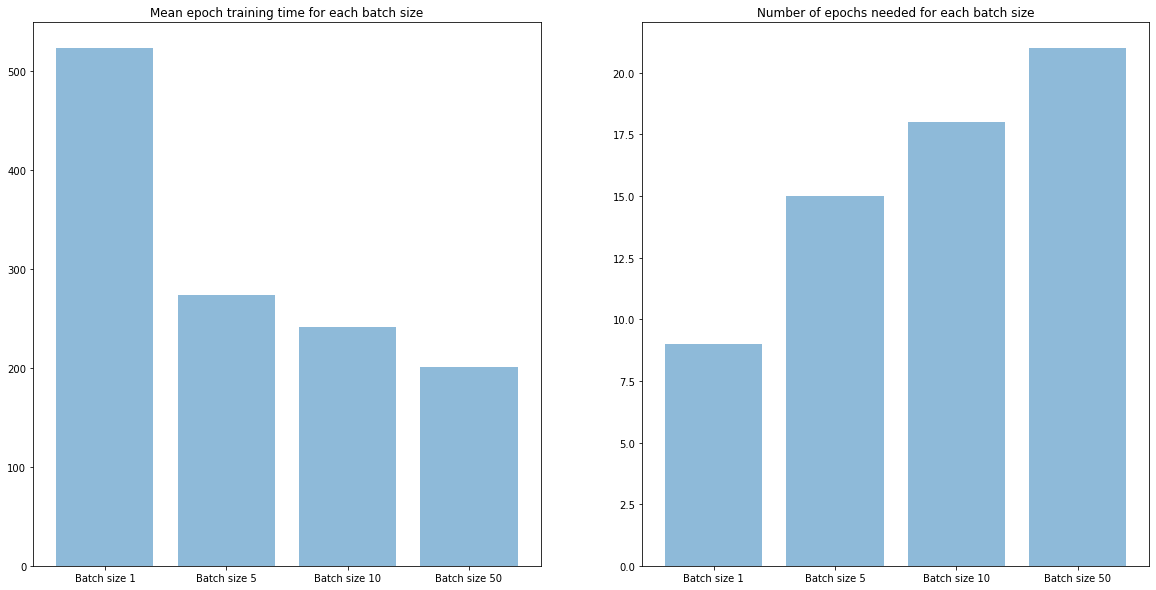

In [51]:
average_epoch_times = [523, 274, 241, 201]
number_epochs = [9, 15, 18, 21]
batch_size = ["Batch size 1", "Batch size 5", "Batch size 10", "Batch size 50"]
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.bar(batch_size, average_epoch_times, align = 'center', alpha = 0.5)
plt.title('Mean epoch training time for each batch size')
plt.subplot(1,2,2)
plt.bar(batch_size, number_epochs, align = 'center', alpha = 0.5)
plt.title('Number of epochs needed for each batch size')